This Notebook will introduce our first Machine Learning algorithm - Decision Trees. These are amongst the most interpretable of algorithms and for certain problems can be just as effective as more complex approaches.

The Decision Tree works by systematically segmenting the data, deriving binary rules which eventually lead to the classification of a record. A system that tries to distinguish between Elephants, Giraffes, and Lions and has two features ("Height" and "Has fur" might use "Height > 2m" as an initial split. A "Has fur?" split will then distinguish between the two taller animals.

We will see during the tutorial that we have a number of parameters to control the output decision tree. These parameters may improve results but can also affect interpretability - this is an important balancing act.

To follow the tutorial read each section of text and then run the Python code below the section.





The following commands connect to GDrive. Running the commands should present an accounts.google.com link. Click to open it in a browser window (where you may be prompted to login in to your Google account and authorise Colabs to access your files) and copy the authorisation code it gives you (there's a little 'double rectangle' which you can click to copy). Then paste the code in the space below, where it says "Enter your authorization code":

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import the libraries used by this tutorial. Libraries contain programmes that people have already written to save you re-inventing the wheel.

In [ ]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score

session_path = '/content/gdrive/My Drive/MLC/Session 2/' # Usually have data_dir but this ariable intended for saving of visualisations too, though those are currently commented out

Test that you can access the data files for this tutorial. After running this cell you should see two files in a list:
 ['zoo.csv','zoo.clean.csv']

In [ ]:
import os
data_dir = session_path + 'Data/'
os.listdir(data_dir)

['us_census_1994.txt', 'zoo.csv', 'zoo.gsheet', 'zoo']

Load the zoo data as we did last time

In [ ]:
zoo_data = pd.read_csv(data_dir + 'zoo.csv', header=None)
zoo_data.columns = ['animalname','hair','feathers','eggs','milk','airborne','aquatic','predator','toothed','backbone', \
                    'breathes','venomous','fins','legs','tail','domestic','catsize','animalclass']
zoo_data.head()

,animalname,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,animalclass
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


Scikit Learn is a fantastic machine learning library which has most of the classic ML algorithms as well as functionality for preparing your data, and even generating synthetic data.

The following command imports the tree module into our environment so we can build a decision tree. There are two types of decision tree - regression and classification. We will be building a classification tree since we are trying to predict the animalclass which has 7 possible values. If we were trying to predict a numeric value like "animal speed" we would use regression.

In [ ]:
from sklearn import tree
import graphviz 

We will start by building a decision tree with a small number of features, we won't use all of them yet. **Run the code below and then we'll pause to discuss the output and how to interpret it**

The first line of code selects the feature columns, the second the target column. Start by experimenting with the names of the columns in line 1. **Does changing the list make any difference to the resulting tree)?**
(remember that zoo_data.columns will give you the list as a reminder of their names).

We strongly recommend working in a team for this exercise so you can all try different combinations of columns and speed up the process.


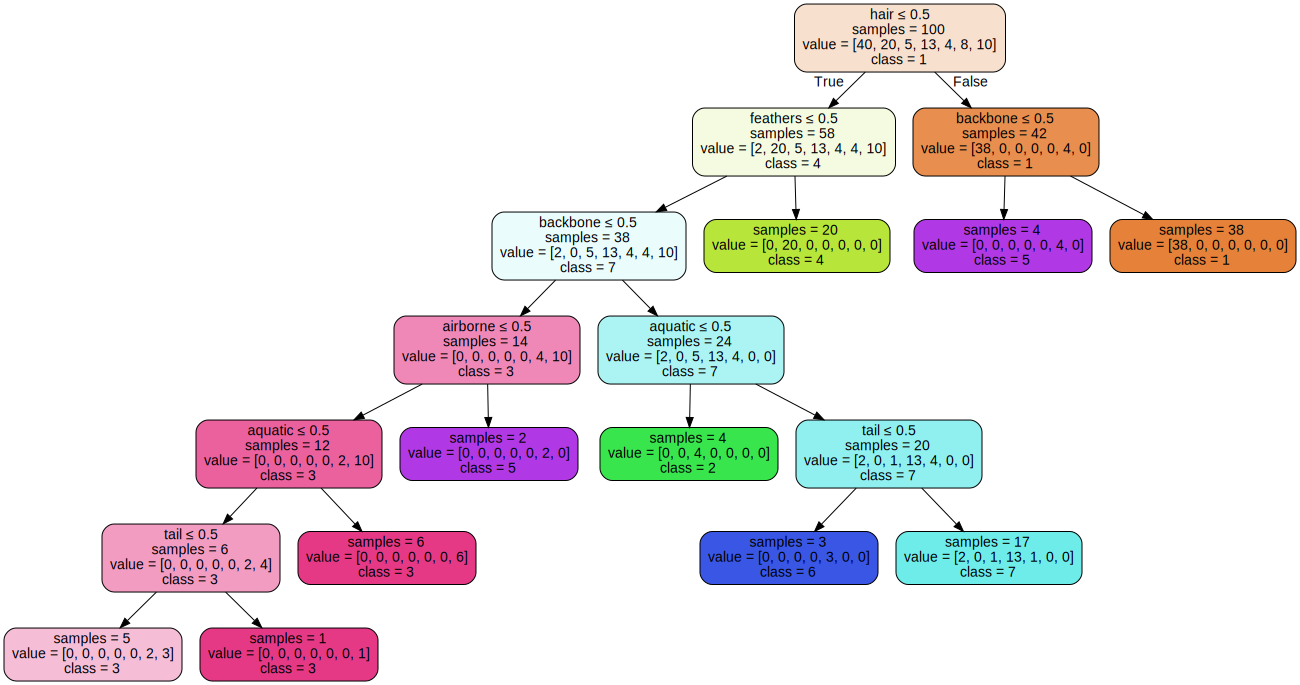

In [ ]:
#####################################
# Adjust this list for first exercise
X = zoo_data[{'hair','feathers','airborne','aquatic','backbone','tail'}]  # Select feature columns
#####################################
Y = zoo_data[{'animalclass'}]                                             # Select the target column
y_vals = [str(y) for y in Y.animalclass.unique()]                         # This is a list of the values for animalclass

#####################
MAX_DEPTH = None  # Adjust this variable in second exercise
#####################

# This piece of code is put into a function to make it reusable later
def outputTree(X, Y, y_vals, max_depth, min_samples_split=2, min_samples_leaf=1, class_weight=None, min_impurity_decrease=0.0):
    clf = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, class_weight=class_weight, min_impurity_decrease=min_impurity_decrease)                            # Set up the Decision Tree Classifier function
    clf = clf.fit(X, Y)                                                       # Build a decision tree by pushing the data into the algorithm

    # These lines visualise the tree and save it to a pdf file in your Google Drive folder
    dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=y_vals, filled=True, rounded=True, impurity=False, special_characters=True)

    graph = graphviz.Source(dot_data) 
    #graph.render(session_path + "Visualisations/zoo_decisions.pdf") # Remove the comment at the beginning to save tree to pdf
    return [graph, clf]

out = outputTree(X, Y, y_vals, MAX_DEPTH)
out[0]

Return to the code above and adjust the MAX_DEPTH variable. **How does this affect your output?**

********* **Again we will pause here to discuss what the output** *********



We will now change datasets and load the census data from Session 1. Have a quick look at the columns to refresh your memory of it.

In [ ]:
census_data = pd.read_csv(data_dir + 'us_census_1994.txt', delimiter="\t")
census_data

,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Do remember how we had to change categorical columns, such as occupation, to 1s and 0s (called "one-hot encoding")?

Good news! Some Decision tree libraries work with categorical values, so we don't need to do that.

Bad news! This isn't one of those libraries.

So we will start by converting all of the categorical variables to the one-hot format. This also involves filling any missing values with defaults.



In [ ]:
census_data.loc[(census_data['workclass'].str.contains('\?')), 'workclass'] = 'Unknown-Workclass'
one_hot_census = pd.get_dummies(census_data[['education', 'maritalstatus', 'relationship', 'race', 'sex', 'workclass','occupation', 'nativecountry', 'salary']],drop_first=True)
one_hot_census = census_data.join(one_hot_census)
#one_hot_census = one_hot_census.drop(['education', 'maritalstatus', 'relationship', 'race', 'sex', 'workclass','occupation', 'nativecountry'], axis=1)
one_hot_census.head(3)

,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,salary,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,maritalstatus_ Married-AF-spouse,maritalstatus_ Married-civ-spouse,maritalstatus_ Married-spouse-absent,maritalstatus_ Never-married,maritalstatus_ Separated,maritalstatus_ Widowed,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,...,nativecountry_ China,nativecountry_ Columbia,nativecountry_ Cuba,nativecountry_ Dominican-Republic,nativecountry_ Ecuador,nativecountry_ El-Salvador,nativecountry_ England,nativecountry_ France,nativecountry_ Germany,nativecountry_ Greece,nativecountry_ Guatemala,nativecountry_ Haiti,nativecountry_ Holand-Netherlands,nativecountry_ Honduras,nativecountry_ Hong,nativecountry_ Hungary,nativecountry_ India,nativecountry_ Iran,nativecountry_ Ireland,nativecountry_ Italy,nativecountry_ Jamaica,nativecountry_ Japan,nativecountry_ Laos,nativecountry_ Mexico,nativecountry_ Nicaragua,nativecountry_ Outlying-US(Guam-USVI-etc),nativecountry_ Peru,nativecountry_ Philippines,nativecountry_ Poland,nativecountry_ Portugal,nativecountry_ Puerto-Rico,nativecountry_ Scotland,nativecountry_ South,nativecountry_ Taiwan,nativecountry_ Thailand,nativecountry_ Trinadad&Tobago,nativecountry_ United-States,nativecountry_ Vietnam,nativecountry_ Yugoslavia,salary_ >50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Before we build our decision tree we will create training and test datasets so that we can evaluate how effective our model is at predicting salary.

The model will learn from the training data, and then we test it against the (you guessed it) test data.

We will use an 80:20 split (80% will be training data) and stratify the resulting datasets. **Look at the graphs and convince yourself that they have the same distribution**

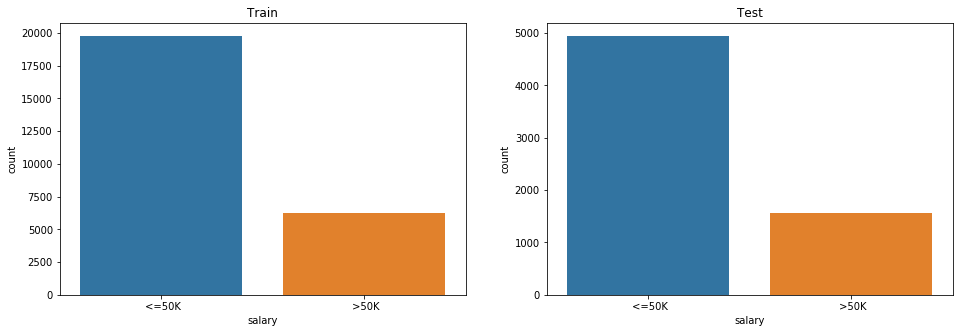

In [ ]:
census_train, census_test = train_test_split(one_hot_census, train_size = 0.8, stratify = census_data.salary)
fig, ax =plt.subplots(1,2, figsize=(16, 5))
sns.countplot(census_train['salary'], ax=ax[0])
sns.countplot(census_test['salary'], ax=ax[1])
ax[0].set_title("Train")
ax[1].set_title("Test")
plt.show()

Now we will build a decision tree. We will start with a MAX_DEPTH of 3 and use all of the columns. Before we adjust any parameters, we will look at how to test our algorithm. Here is a reminder of the columns in the original data for later reference.

In [ ]:
census_data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educationnum',
       'maritalstatus', 'occupation', 'relationship', 'race', 'sex',
       'capitalgain', 'capitalloss', 'hoursperweek', 'nativecountry',
       'salary'],
      dtype='object')

Let's build the tree first, and then we'll test it. **Take some time to examine the output, is it what you expected?**


*   **Are all the variables used?**
*   **Do the splits it makes make sense?**
*   **Do you see any redundancy in the tree?**


['age', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'workclass_Unknown-Workclass', 'educationnum', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Priv-house-serv', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'occupation_ Transport-moving', 'maritalstatus_ Married-AF-spouse', 'maritalstatus_ Married-civ-spouse', 'maritalstatus_ Married-spouse-absent', 'maritalstatus_ Never-married', 'maritalstatus_ Separated', 'maritalstatus_ Widowed', 'relationship_ Not-in-family', 'relationship_ Other-relative', 'relationship_ Own-child', 'relationship_ Unmarried', 'relationship_ Wife', 'race_ Asian

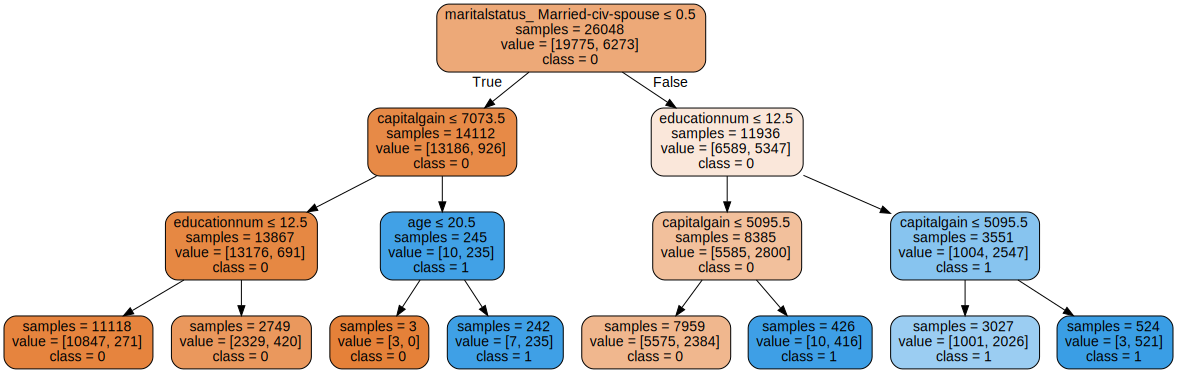

In [ ]:
feature_columns = ['age', 'workclass_', 'educationnum', 'occupation_', 'maritalstatus_', 'relationship_', 'race_', 'sex_', 'nativecountry_', 'capitalgain', 'capitalloss', 'hoursperweek']  # Set feature columns
feature_columns = [j for i in feature_columns for j in census_train.columns if i == j[0:len(i)]]
print(feature_columns)
X_train = census_train[feature_columns]
#####################################
y_train = census_train[{'salary_ >50K'}]                                             # Select the target column
y_vals = list(set([str(y) for y in y_train['salary_ >50K']]))                        # This is a list of the values for animalclass

####################################
# Parameters to adjust
MAX_DEPTH = 3                # Try ranging from 1 to 6
MIN_SAMPLES_SPLIT = 2        # Try ranging from 1 to 40
MIN_SAMPLES_LEAF = 1         # Try rannging from 2 to 20
MIN_IMPURITY_DECREASE = 0.0  # Try between 0.0 and 0.2
#####################################

out = outputTree(X_train, y_train, y_vals,
                 MAX_DEPTH, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,
                 min_impurity_decrease=MIN_IMPURITY_DECREASE)
out[0]

Now we are ready to evaluate the algorithm. The following code will produce what is known as a "Confusion Matrix". The idea is that the rows represent the true salary values and the columns represent the predicted salary values. Each row adds to 1 (with rounding errors) and you can interpret the cells as follows:

*   Row 1, Column 1: Percentage of 0s predicted as 0. "True Negatives"
*   Row 1, Column 2: Percentage of 0s predicted as 1. "False Positives"
*   Row 2, Column 1: Percentage of 1s predicted as 0. "False Negatives"
*   Row 2, Column 2: Percentage of 1s predicted as 1. "True Positives"

The code creates a confusion matrix for Training (left) and Test (right), and also outputs figures for Accuracy, Balanced Accuracy, and something called the F1 Score (see the Appendix at the end if you're interested to know what this is). Just focusing on the first of those figures for now, the accuracy is pretty good for this particular dataset (best I've seen online is 88%).

The top row is looking great too. When a record is type 0 (<=50K), the algorithm predicts it correctly 95% of the time.

**What happens when the true value is 1, how do the predictions look now?**

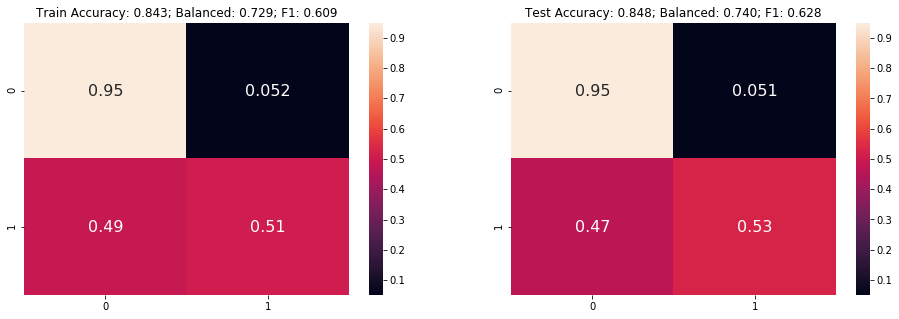

In [ ]:
y_train_pred = out[1].predict(X_train)
X_test = census_test[feature_columns]
y_test = census_test['salary_ >50K']
y_test_pred = out[1].predict(X_test)
fig, ax = plt.subplots(1,2, figsize=(16, 5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, y_train_pred, normalize='true'), range(2), range(2)), annot=True, annot_kws={"size": 16}, ax=ax[0])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred, normalize='true'), range(2), range(2)), annot=True, annot_kws={"size": 16}, ax=ax[1])
ax[0].set_title("Train Accuracy: %0.3f; Balanced: %0.3f; F1: %0.3f" % (accuracy_score(y_train, y_train_pred), balanced_accuracy_score(y_train, y_train_pred), f1_score(y_train, y_train_pred)))
ax[1].set_title("Test Accuracy: %0.3f; Balanced: %0.3f; F1: %0.3f" % (accuracy_score(y_test, y_test_pred), balanced_accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred)))
plt.show()


Let's remind ourselves of one of the first graphs we drew of this data

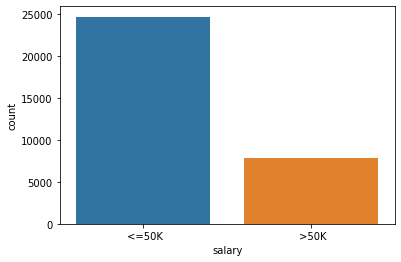

In [ ]:
sns.countplot(census_data['salary'])


Unbalanced datasets are always a challenge in machine learning. The algorithm optimises itself so that overall it gets the best accuracy score which means it will tend towards correctly weighting the factors which predict the largest class.

This time we will run the code again but with an extra parameter passed to the algorithm: class_weight = 'balanced'

What this parameter does is tell the algorithm to assign more weight to the >50K class when it is deciding how to proceed at each split. This feature isn't always available so for other ML algorithms or libraries we would need to handle the imbalance ourselves. One way of tackling this problem is to sample your data in such a way that you have equal numbers of each class.

You can see evidence of the algorithm applying this weighting by looking at the class split in the first box of the decision tree. It appears it is now 50:50 (approx 13k each) but the record count hasn't changed and it hasn't magically converted some of the low salary records to high. Also notice that the counts have become decimals rather than whole numbers, this is an affect of the weighting.

['age', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'workclass_Unknown-Workclass', 'educationnum', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Priv-house-serv', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'occupation_ Transport-moving', 'maritalstatus_ Married-AF-spouse', 'maritalstatus_ Married-civ-spouse', 'maritalstatus_ Married-spouse-absent', 'maritalstatus_ Never-married', 'maritalstatus_ Separated', 'maritalstatus_ Widowed', 'relationship_ Not-in-family', 'relationship_ Other-relative', 'relationship_ Own-child', 'relationship_ Unmarried', 'relationship_ Wife', 'race_ Asian

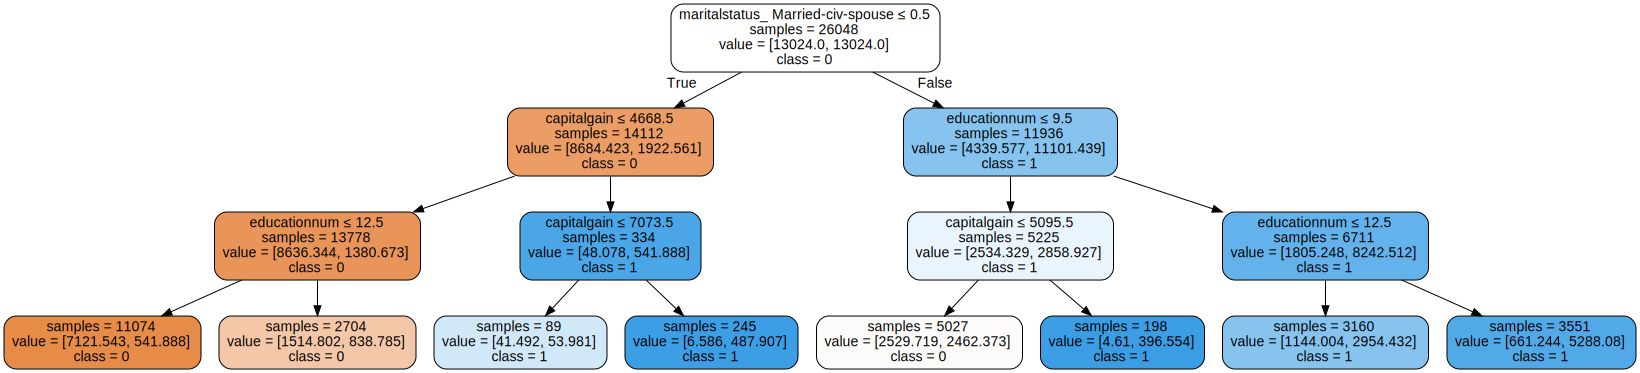

In [ ]:
#####################################
# Adjust this list for first exercise
feature_columns = ['age', 'workclass_', 'educationnum', 'occupation_', 'maritalstatus_', 'relationship_', 'race_', 'sex_', 'nativecountry_', 'capitalgain', 'capitalloss', 'hoursperweek']  # Set feature columns
feature_columns = [j for i in feature_columns for j in census_train.columns if i == j[0:len(i)]]
print(feature_columns)
X_train = census_train[feature_columns]
#####################################
y_train = census_train[{'salary_ >50K'}]                                             # Select the target column
y_vals = list(set([str(y) for y in y_train['salary_ >50K']]))                        # This is a list of the values for animalclass

####################################
# Parameters to adjust
MAX_DEPTH = 3                # Try ranging from 1 to 6
MIN_SAMPLES_SPLIT = 2        # Try ranging from 1 to 40
MIN_SAMPLES_LEAF = 1         # Try rannging from 2 to 20
MIN_IMPURITY_DECREASE = 0.0  # Try between 0.0 and 0.2
#####################################

out = outputTree(X_train, y_train, y_vals,
                 MAX_DEPTH, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,
                 min_impurity_decrease=MIN_IMPURITY_DECREASE, class_weight='balanced')
out[0]

Now if we redraw the confusion matrix we have a different picture. Our accuracy has actually gone down, but the 'balanced accuracy' has gone up from last time.

**Have you noticed how similar the Train and Test figures and graphs are?** This is good news, it means we are not overfitting our data.

Now the next stage is to start trying to tune our decision tree. There's a reasonable chance that any tuning you do will make it worse for this particular dataset, but it is an opportunity to see how we can manipulate the algorithm. It is also a first chance to think about interpretability.

**Start by forming teams of 4 people**

The code above has 4 parameters that can be changed. In your teams, each person will take responsibility for experimenting with one of those variables. You can do this by alternating between changing your variable, running the code, and then rerunning the evaluation code. **Then report back to your team to tell them what you think it does and what effect it has on the results of your decision tree model.** Think of both the accuracy results but also the appearance of the output tree.

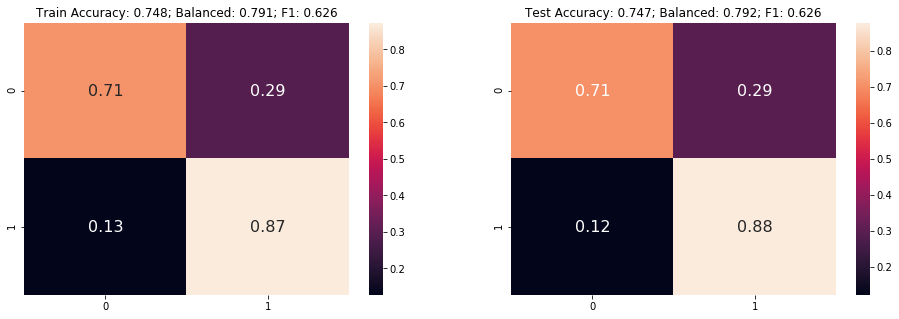

In [ ]:
y_train_pred = out[1].predict(X_train)
X_test = census_test[feature_columns]
y_test = census_test['salary_ >50K']
y_test_pred = out[1].predict(X_test)
fig, ax = plt.subplots(1,2, figsize=(16, 5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, y_train_pred, normalize='true'), range(2), range(2)), annot=True, annot_kws={"size": 16}, ax=ax[0])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred, normalize='true'), range(2), range(2)), annot=True, annot_kws={"size": 16}, ax=ax[1])
ax[0].set_title("Train Accuracy: %0.3f; Balanced: %0.3f; F1: %0.3f" % (accuracy_score(y_train, y_train_pred), balanced_accuracy_score(y_train, y_train_pred), f1_score(y_train, y_train_pred)))
ax[1].set_title("Test Accuracy: %0.3f; Balanced: %0.3f; F1: %0.3f" % (accuracy_score(y_test, y_test_pred), balanced_accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred)))
plt.show()

An extension of the Decision Tree algorithm is the Random Forest. In basic terms it generates potentially hundreds of decision trees from random samples. It then predicts by averaging across the results from all the trees. We'll look at again in Session 3, but here it provides a good example of overfitting. **Compare the Train and Test accuracy results from the below code**

This is slightly ironic since one of the benefits of random forest is that it reduces the risk of overfitting. We could tune this as we did before, but this is only for illustrative purposes.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


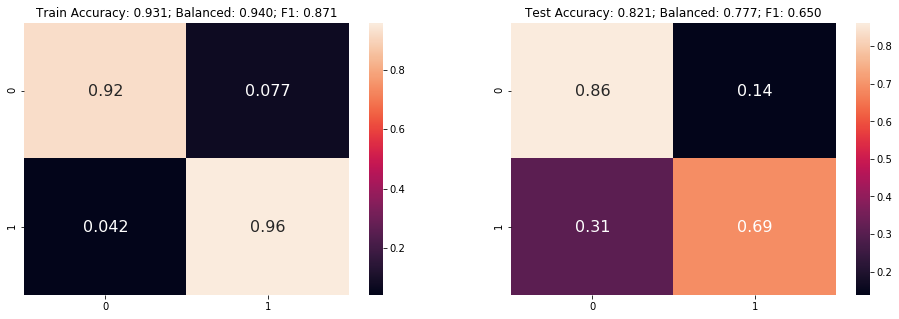

In [ ]:
from sklearn.ensemble import RandomForestClassifier
feature_columns = ['age', 'workclass_', 'educationnum', 'maritalstatus_', 'sex_', 'capitalgain', 'hoursperweek', 'race_']  # Set feature columns
feature_columns = [j for i in feature_columns for j in census_train.columns if i == j[0:len(i)]]
X_train = census_train[feature_columns]
clf = RandomForestClassifier(n_estimators = 200, max_depth=None, random_state=0, class_weight='balanced_subsample') #, min_impurity_decrease = 0.008)
clf.fit(X_train, y_train)
#print(clf.feature_importances_)

y_train_pred = clf.predict(X_train)
X_test = census_test[feature_columns]
y_test = census_test['salary_ >50K']
y_test_pred = clf.predict(X_test)
fig, ax = plt.subplots(1,2, figsize=(16, 5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, y_train_pred, normalize='true'), range(2), range(2)), annot=True, annot_kws={"size": 16}, ax=ax[0])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred, normalize='true'), range(2), range(2)), annot=True, annot_kws={"size": 16}, ax=ax[1])
ax[0].set_title("Train Accuracy: %0.3f; Balanced: %0.3f; F1: %0.3f" % (accuracy_score(y_train, y_train_pred), balanced_accuracy_score(y_train, y_train_pred), f1_score(y_train, y_train_pred)))
ax[1].set_title("Test Accuracy: %0.3f; Balanced: %0.3f; F1: %0.3f" % (accuracy_score(y_test, y_test_pred), balanced_accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred)))
plt.show()

That's the end of this tutorial in which you have learned the following about decision trees:

1.   How to create a decision tree
2.   How to identify and deal with unbalanced (biased) data

1.   How to numerically evaluate the output of an ML classification algorithm
2.   How to interpret a confusion matrix

1.   How to spot overfitting















Appendix: Accuracy and F1 Scores

This section is to explain how accuracy scores are calculated for a binary classification task.

If you remember the confusion matrix the cells were given names: True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN).

Accuracy tells us the overall performance of the model and is calculated as follows:

$\frac{TP + TN}{TP + FN + TN + FP}$

In other words, how many did it get right out of all the predictions?

We can also introduce the concepts of Precision and Recall, which give a more nuanced view.

Precision is a measure of how accurate the positive predictions are. When it returns a 1, how likely is it to be correct? This is calculated by the formula:

$\frac{TP}{TP+FP}$

Recall tells us what percentage of the positive values are being predicted as positive.

$\frac{TP}{TP+FN}$

Precision and Recall are important metrics for evaluating an ML system and we may tune our algorithm more towards one than the other. Imagine a system which predicts whether it is safe to drive through a junction. You really want that to be right when it says it is safe. In which case we need high precision.

Alternatively, imagine a search system which predicts whether you want to see a particular document or not. You may want to be sure that you never miss a document, but are willing to accept some false positives too. That system would have high recall.

Finally we have the F1 Score which is a metric particularly relevant to imbalanced datasets. It is calculated as follows:

$\frac{2TP}{2TP+FP+FN}$